In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve


import matplotlib.pyplot as plt
%matplotlib inline

# Data prep

In [2]:
df_truth = pd.read_csv("/jupyter-nfs/data/Liberia/ground_truth/schools_SE_200.csv")
df_truth["image_name"] = df_truth.image.apply(lambda x: x.split("/")[-1])
df_truth.head()

,image,num_schools,image_name
0,/media/sf_Big_Pixel/unicef/Liberia/Rural/south...,0,Sanniquellie_SE__9800_57400.tif
1,/media/sf_Big_Pixel/unicef/Liberia/Rural/south...,0,Sanniquellie_SE__9800_57600.tif
2,/media/sf_Big_Pixel/unicef/Liberia/Rural/south...,0,Sanniquellie_SE__9800_57800.tif
3,/media/sf_Big_Pixel/unicef/Liberia/Rural/south...,0,Sanniquellie_SE__9800_5800.tif
4,/media/sf_Big_Pixel/unicef/Liberia/Rural/south...,0,Sanniquellie_SE__9800_58000.tif


In [3]:
df = pd.read_csv("../features/rural-ResNet50-pool.csv")
df.head()

,image_paths,pool5.0,pool5.1,pool5.2,pool5.3,pool5.4,pool5.5,pool5.6,pool5.7,pool5.8,...,pool5.2038,pool5.2039,pool5.2040,pool5.2041,pool5.2042,pool5.2043,pool5.2044,pool5.2045,pool5.2046,pool5.2047
0,/jupyter-nfs/data/Liberia/rural/southeast_tile...,0.137256,0.033329,0.243107,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.147094,0.000000,0.0
1,/jupyter-nfs/data/Liberia/rural/southeast_tile...,1.413542,0.016365,0.089910,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.284178,0.0,0.0,0.068741,0.0,0.0,0.0,0.000000,0.022701,0.0
2,/jupyter-nfs/data/Liberia/rural/southeast_tile...,0.106881,0.000000,0.070017,0.026601,0.009001,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.001180,0.0,0.0,0.0,0.132630,0.000000,0.0
3,/jupyter-nfs/data/Liberia/rural/southeast_tile...,0.405045,0.009956,0.000000,0.000000,0.045935,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.015846,0.000000,0.0
4,/jupyter-nfs/data/Liberia/rural/southeast_tile...,0.279609,0.000000,0.409207,0.000000,0.021985,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.003470,0.000000,0.0


In [4]:
print("Ground truth file shape:", df_truth.shape)
print("Features file shape:", df.shape)

Ground truth file shape: (71447, 3)
Features file shape: (71448, 2049)


In [5]:
df["image_name"] = df.image_paths.apply(lambda x: x.split("/")[-1])
df_truth["image_name"] = df_truth.image.apply(lambda x: x.split("/")[-1])

df_merged = df_truth.merge(df)

# Classify 

In [6]:
# select features and labels
X = np.array(df_merged.filter(regex="pool5.*"))
y = np.array(df_merged.num_schools)

In [7]:
# some images have more than one school; clip so that we define a binary label
# school vs. no school
y[y>0] = 1

In [8]:
clf = LogisticRegressionCV(class_weight="balanced", random_state = 0, 
                           scoring= "average_precision", n_jobs = -2)

In [9]:
%%time
np.random.seed(42)
scores = cross_val_score(clf, X, y, cv = 5, scoring= "average_precision")


CPU times: user 13min 58s, sys: 8min 16s, total: 22min 14s
Wall time: 12min 8s


In [10]:
print("Average precision is averaged over all folds", np.mean(scores))

Average precision is averaged over all folds 0.382295469631


Average percision for each fold:

In [11]:
scores

array([ 0.18087483,  0.38134178,  0.56833745,  0.5244456 ,  0.25647769])

## Further evaluations of logistic regression model

In [12]:
## plotting precision recall curves wrapper
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_test, y_score, title = ""):
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title)

In [ ]:
%%time 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
LR = LogisticRegressionCV(cv = 10, n_jobs=-2, random_state = 42, class_weight="balanced")
LR.fit(X_train, y_train)
y_scores = LR.predict_proba(X_test)[:,1]

AUC = roc_auc_score(y_test, y_scores)
avg_prec = average_precision_score(y_test, y_scores)

CPU times: user 54.9 s, sys: 51.2 s, total: 1min 46s
Wall time: 6min 3s


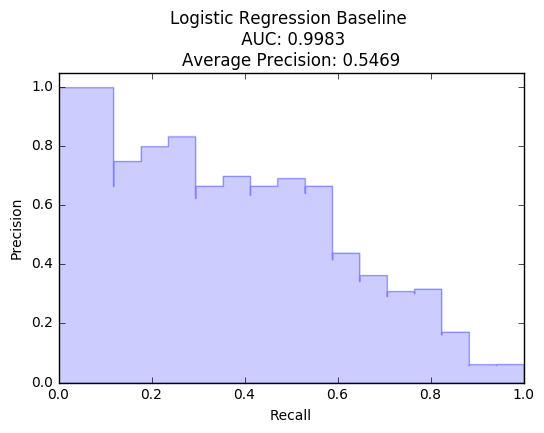

In [ ]:
plot_precision_recall_curve(y_test, LR.predict_proba(X_test)[:,1], 
                            "Logistic Regression Baseline \n AUC: {0:0.4f}".format(AUC) 
                            + "\nAverage Precision: {0:0.4f}".format(avg_prec))

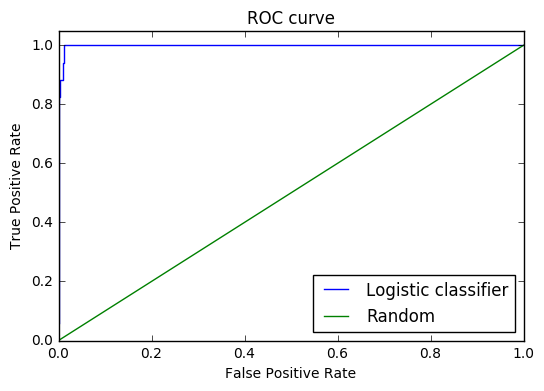

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.legend(["Logistic classifier", "Random"], loc = "lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("ROC curve")

In [ ]:
%%time
weighted_f1_scores = cross_val_score(clf, X, y, cv = 5, scoring= "f1_weighted")

In [18]:
np.mean(weighted_f1_scores)

0.99809572888074616